기초분석
1. 기본 시각화
	1. 지역별 가장 리뷰가 많고 별점이 높은 맛집
	2. 리뷰 단어 빈도수 히스토그램 및 워드클라우드(전체/지역별)
2. 지도에 특정 음식점이 모여있는 지역 표시(STORE의 카테고리 통해)
심화 분석
1. 감성분석 통해 리뷰 예측((https://wikidocs.net/44249),(https://chaelist.github.io/docs/ml_application/sentiment_analysis/))
2. 리뷰 기반 맛집 추천(https://data101.oopy.io/recommendation-engine-cosine-similarity)
3. word2vec 사용해 특정 단어와 유사한 단어 추출(https://wikidocs.net/50739)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [ ]:
'''#한글 깨짐 현상 수정
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf'''

In [ ]:
!pip install konlpy

In [5]:
# 사용할 library를 먼저 모두 import
import pandas as pd
import numpy as np
import konlpy
import re
from sklearn.feature_extraction.text import CountVectorizer   # tf-idf 방식을 사용하려면 대신 TfidfVectorizer를 import
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

In [7]:
reviews_df = pd.read_csv('rating_df.csv', encoding='utf-8')
reviews_df.drop(['Unnamed: 0'], axis=1, inplace=True)
reviews_df.head()

,review_code,place_code,ItemID,UserID,review,Rating,Timestamp
0,SB000001,STORE_SB0001,성북동메밀수제비누룽지백숙,te9a7m,너무비싸,2.0,2021.08.08.
1,SB000002,STORE_SB0001,성북동메밀수제비누룽지백숙,7kup8e,맛은 좋으나 기다림이 문제,3.0,2021.07.14.
2,SB000003,STORE_SB0001,성북동메밀수제비누룽지백숙,fkfake,NaN,3.0,2021.06.26.
3,SB000004,STORE_SB0001,성북동메밀수제비누룽지백숙,g8k5fl,들깨수제비까지 욕심부리면 배터집니다. 백숙과 메일전이면 충분 남은 음식 포장 가능,4.0,2021.06.20.
4,SB000005,STORE_SB0001,성북동메밀수제비누룽지백숙,n5mvk0,굿 애프터하이크 푸드,4.0,2021.05.23.


In [8]:
reviews_df.isna().sum()

review_code       0
place_code        0
ItemID            0
UserID         4592
review         2945
Rating         1412
Timestamp         0
dtype: int64

In [9]:
#결측치 제거
reviews = reviews_df.dropna(axis=0)

In [10]:
reviews.isna().sum()

review_code    0
place_code     0
ItemID         0
UserID         0
review         0
Rating         0
Timestamp      0
dtype: int64

In [11]:
reviews.head()

,review_code,place_code,ItemID,UserID,review,Rating,Timestamp
0,SB000001,STORE_SB0001,성북동메밀수제비누룽지백숙,te9a7m,너무비싸,2.0,2021.08.08.
1,SB000002,STORE_SB0001,성북동메밀수제비누룽지백숙,7kup8e,맛은 좋으나 기다림이 문제,3.0,2021.07.14.
3,SB000004,STORE_SB0001,성북동메밀수제비누룽지백숙,g8k5fl,들깨수제비까지 욕심부리면 배터집니다. 백숙과 메일전이면 충분 남은 음식 포장 가능,4.0,2021.06.20.
4,SB000005,STORE_SB0001,성북동메밀수제비누룽지백숙,n5mvk0,굿 애프터하이크 푸드,4.0,2021.05.23.
5,SB000006,STORE_SB0001,성북동메밀수제비누룽지백숙,1dtoiih,좋아 함. 그래서 자주 감. 근데 닭보다 누룽지가 훨 맛있음. 누룽지를 먹기 위해 ...,4.0,2021.05.13.


In [12]:
# 텍스트를 tokenize해서 adjective, verb, noun만 추출하는 함수

def tokenize_korean_text(text): 
    text_filtered = re.sub('[^,.?!\w\s]','', text)

    okt = konlpy.tag.Okt() 
    Okt_morphs = okt.pos(text_filtered) 

    words = []
    for word, pos in Okt_morphs:
        if pos == 'Adjective' or pos == 'Verb' or pos == 'Noun':
            words.append(word)

    words_str = ' '.join(words)
    return words_str

In [13]:
X_texts = []
y = []

for star, comment in zip(reviews['Rating'], reviews['review']):

  tokenized_comment = tokenize_korean_text(comment)  # 위에서 만들었던 함수로 comment 쪼개기
  X_texts.append(tokenized_comment)

  y.append(1 if star > 3 else -1)
    # 평점이 8 이상이면(8,9,10) 값을 1로 지정 (positive)
    # 평점이 3 이하이면(1,2,3) 값을 -1로 지정 (negative)

print(f'원래 text 수: {len(reviews)}')
# print(f'평점 3 이하 혹은 8 이상인 text 수: {len(X_texts)}')
print(X_texts[:5])

원래 text 수: 9086
['비싸', '맛 좋으나 기다림 문제', '들깨 수제비 욕심 부리면 배 터집니다 백숙 메일 전이 충분 남은 음식 포장 가능', '굿 애프터 이크 푸드', '좋아 함 자주 감 닭 누룽지 훨 맛있음 누룽지 먹기 위해 닭백숙 시켜야 하는 슬픈 현실 센터 살코기 조금 넣고 누룽지 죽 메뉴 좀 파세요 인분 먹을 의향 있음']


## Logistic Regression으로 학습
train_test_split & vector화


In [14]:
# train_test_split
X_train_texts, X_test_texts, y_train, y_test = train_test_split(X_texts, y, test_size=0.2, random_state=0)

In [15]:
# CountVectorizer로 vector화
tf_vectorizer = CountVectorizer(min_df=1, ngram_range=(1,1))
X_train_tf = tf_vectorizer.fit_transform(X_train_texts)  # training data에 맞게 fit & training data를 transform
X_test_tf = tf_vectorizer.transform(X_test_texts) # test data를 transform

vocablist = [word for word, number in sorted(tf_vectorizer.vocabulary_.items(), key=lambda x:x[1])]  # 단어들을 번호 기준 내림차순으로 저장

In [16]:
## 확인해보기
print(X_train_tf[:1], '\n')
print(X_test_tf[:1], '\n')
print(vocablist[:3])

  (0, 4980)	1
  (0, 8620)	1
  (0, 14701)	1
  (0, 5820)	1
  (0, 7470)	1
  (0, 13214)	1
  (0, 12503)	1
  (0, 5657)	1
  (0, 5803)	1
  (0, 980)	1
  (0, 3497)	1 

  (0, 15)	1
  (0, 544)	1
  (0, 1017)	1
  (0, 1530)	1
  (0, 1720)	1
  (0, 5439)	1
  (0, 5946)	1
  (0, 6932)	1
  (0, 6986)	1
  (0, 9004)	1
  (0, 9227)	1
  (0, 11152)	1
  (0, 11386)	1
  (0, 13214)	1
  (0, 13498)	1
  (0, 14506)	1
  (0, 14817)	1
  (0, 16424)	1 

['가게', '가게네요', '가게되']


학습 & test data 예측


In [17]:
model = LogisticRegression(C=0.1, penalty='l2', random_state=0)
model.fit(X_train_tf, y_train)  # 학습

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
y_test_pred = model.predict(X_test_tf)

print('Misclassified samples: {} out of {}'.format((y_test_pred != y_test).sum(), len(y_test)))
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_test_pred)))  # model.score(X_test_tf, y_test)로 계산해도 됨

Misclassified samples: 325 out of 1818
Accuracy: 0.82


예측에 중요한 역할을 하는 단어들 확인

In [26]:
coefficients = model.coef_.tolist()

sorted_coefficients = sorted(enumerate(coefficients[0]), key=lambda x:x[1], reverse=True)
# coefficients(계수)가 큰 값부터 내림차순으로 정렬

print('긍정적인 단어 Top 10 (높은 평점과 상관관계가 강한 단어들)')
for word_num, coef in sorted_coefficients[:10]:
  print('{0:}({1:.3f})'.format(vocablist[word_num], coef))

print('\n부정적인 단어 Top 10 (낮은 평점과 상관관계가 강한 단어들)')
for word_num, coef in sorted_coefficients[-10:]: 
  print('{0:}({1:.3f})'.format(vocablist[word_num], coef))

긍정적인 단어 Top 10 (높은 평점과 상관관계가 강한 단어들)
맛있어요(1.783)
최고(1.522)
맛있고(1.158)
존맛(1.150)
좋아요(1.114)
친절하시고(0.933)
맛있음(0.907)
맛있었어요(0.887)
맛있습니다(0.885)
맛있네요(0.862)

부정적인 단어 Top 10 (낮은 평점과 상관관계가 강한 단어들)
시켰는데(-0.673)
마세요(-0.676)
실망(-0.680)
다신(-0.717)
없음(-0.748)
손님(-0.774)
그냥(-0.931)
최악(-1.076)
별로(-1.100)
불친절(-1.208)


새로운 댓글의 긍정/부정 예측해보기
: 학습에 포함되지 않았던 영화인 ‘인턴‘에서 댓글을 가져와서 테스트

In [21]:
# 긍정/부정 테스트용 함수 생성
def guess_good_or_bad(text):
  text_filtered = text.replace('.', '').replace(',','').replace("'","").replace('·', ' ').replace('=','') 

  okt = konlpy.tag.Okt() 
  Okt_morphs = okt.pos(text_filtered) 

  words = []
  for word, pos in Okt_morphs:
    if pos == 'Adjective' or pos == 'Verb' or pos == 'Noun':
      words.append(word)
  words_str = ' '.join(words)
  
  new_text_tf = tf_vectorizer.transform([words_str])

  if model.predict(new_text_tf) == 1:
    print('긍정')
  else:
    print('부정')

In [22]:
guess_good_or_bad('고기랑 채소는 엄청 신선해요~ 사이드 메뉴인 치킨은.. 넘 퍽퍽하네요ㅜㅜ 고기가 맛있어요~! 매장에 기름이 많아서 미끄러우니 조심하세요~^^;; 고기 퀄리티와 맛은 좋아요~!')

긍정


In [23]:
guess_good_or_bad('별로네요, 인테리어도 칙칙하고 가게에서 냄새도 나요. 음식도 덜 익어서 나왔고 다신 안 올거 같아요')

부정


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


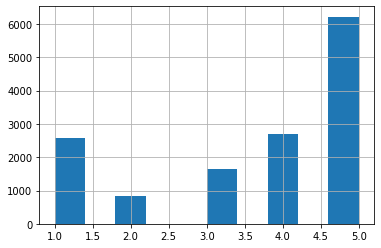

In [24]:
reviews_df['Rating'].hist()